# Create a signal for demonstrating the PFB and its "inversion"

In [1]:
from numpy import sin, arange, pi, shape, log10, zeros

import scipy
from scipy.signal import lfilter, firwin,kaiser,kaiser_beta
from matplotlib import pyplot as plt

from random import random, gauss
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
import numpy as np
import math
import cmath

%matplotlib inline



In [2]:
def db(x):
    """ Convert linear value to dB value """
    return 10*log10(x)

In [3]:
def inv_dft(input,chan):
  output=[]
  stfft = input[0:chan]
  stfft=ifftshift(stfft);
  out=ifft(stfft)
  for samp in out:
    output.append(samp)
  return output


In [4]:
def plot_power(t,amps,keyname="power"):
    power = [abs(s)**2 for s in amps]
    plt.plot(t[:len(power)],power,label = keyname)
    plt.xlabel("Time (s)")
    plt.ylabel("Power")
    plt.legend(loc='upper right')


----------------
## Make a signal:

In [5]:
# Set up the signal properties

nchan = 32
ntaps = 8

nsamp = 10000
nsamples = nsamp*nchan
sample_rate = nchan*nsamp

In [6]:
def make_signal(nsamples,sample_rate):
    """Makes a signal composed of complex-valued white noise"""
    t = []
    signal = []
    for i in range (0,nsamples,1):
        t.append(i * 1.0/sample_rate)
        signal.append(complex(gauss(0.0,1.0),gauss(0.0,1.0)))
    
    return t, signal

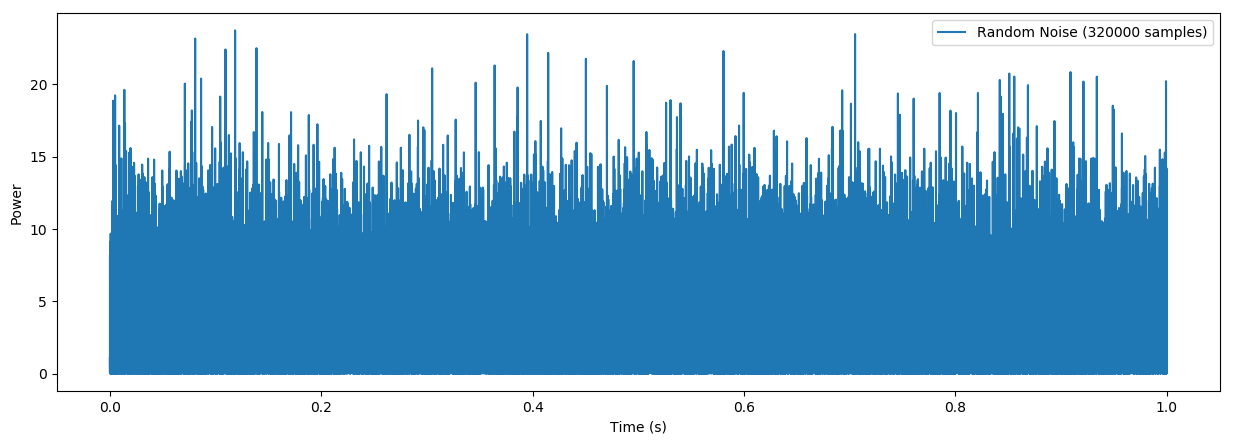

In [7]:
# Make random noise
t, noise = make_signal(nsamples,sample_rate)

# Plot it up
plt.figure(figsize=(15,5))
plot_power(t, noise, "Random Noise ({:d} samples)".format(nsamples))


In [8]:
# Add an impulse to the noise signal

def add_impulse (step,width,scale,signal):
    """ This is multiplicative. I am increasing the power in the specified range """
    result = []
    for i in range(len(signal)):
        result.append(signal[i])
        if (i>step) and (i<=(step+width)):
            result[i] *= scale
    return result

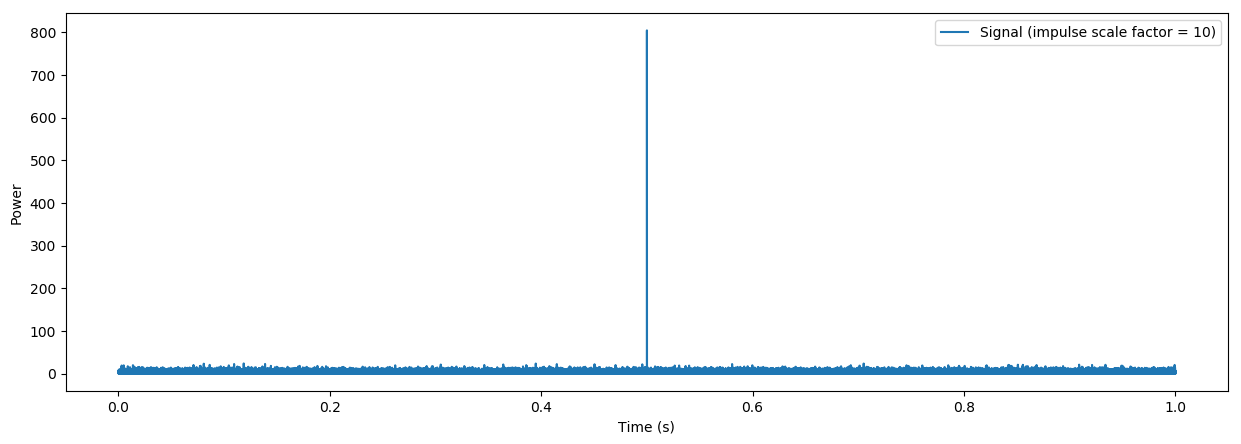

In [9]:
step  = 0.5*nsamples
width = nchan
scale = 10
noise_with_impulse = add_impulse(step,width,scale,noise)

# Plot it up
plt.figure(figsize=(15,5))
plot_power(t, noise_with_impulse, "Signal (impulse scale factor = {:d})".format(scale))


In [10]:
def add_wave(freq,scale,t,signal):
    result = [signal[i]+complex(2*scale*math.cos(2*pi*freq*t[i]),0) for i in range(len(signal))]
    return result

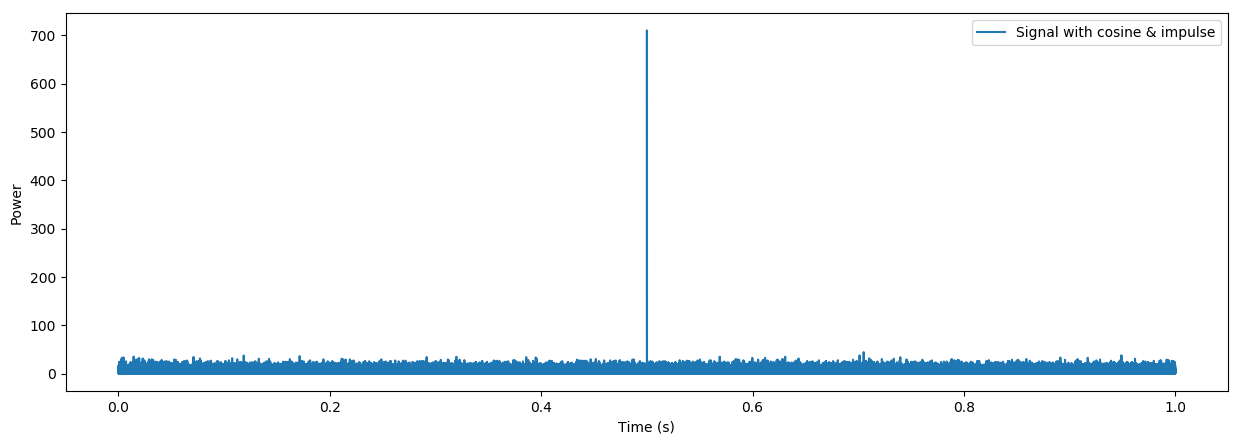

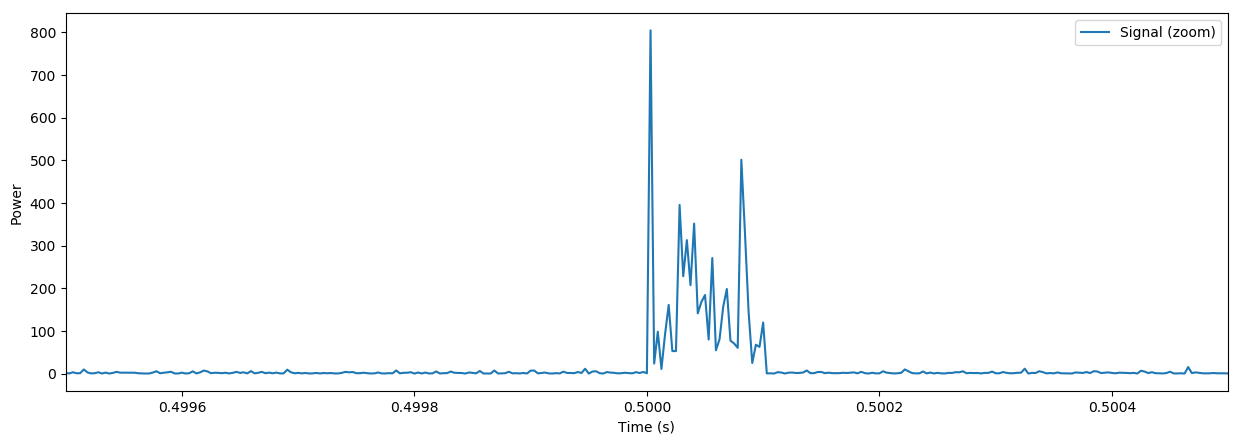

In [42]:
# Add a cosine wave to the signal
freq  = 20000.0
scale = 1.0
signal = add_wave(freq, scale, t, noise_with_impulse)

# Plot it up
plt.figure(figsize=(15,5))
plot_power(t, signal, "Signal with cosine & impulse")
plt.show()

plt.figure(figsize=(15,5))
plot_power(t, noise_with_impulse, "Signal (zoom)")
plt.xlim([0.4995,0.5005])
plt.show()

Text(0.5,0,u'Freq (Hz)')

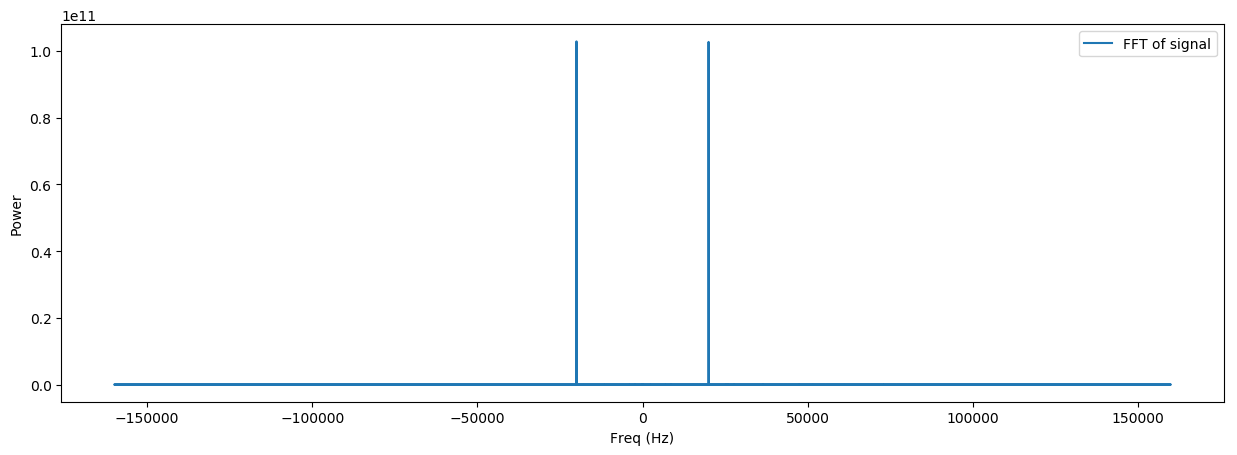

In [25]:
# The spectrogram

spectrum = fft(signal)
freq = fftfreq(len(spectrum), t[1] - t[0])

# Plot it up
plt.figure(figsize=(15,5))
plot_power(freq, spectrum, "FFT of signal")
plt.xlabel("Freq (Hz)")    


----------------------
## Put the signal through a PFB:

In [26]:
def make_filter(numtaps,nchan):
  cof_bit = 12
  ncoeff = numtaps*nchan
  b = firwin(ncoeff,1.0/(nchan))
  b = (1-pow(2,-(cof_bit-1)))*b/max(b);
  window = kaiser(ncoeff,5)
  filter = b*window
  return filter



31.991962694199696


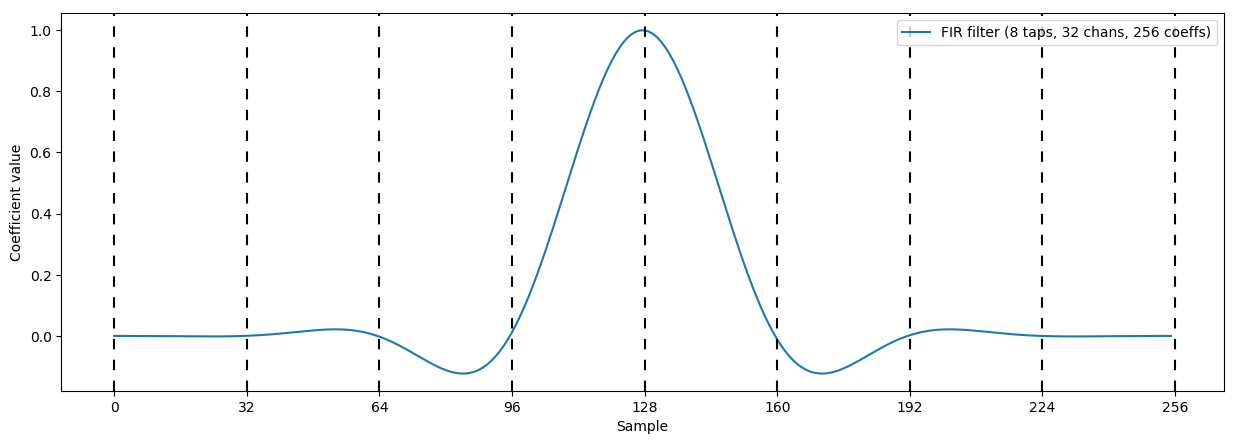

In [27]:
# The Nyquist rate of the signal.
nyq_rate =  sample_rate
cutoff_hz = nyq_rate;

# Use firwin to create a lowpass FIR filter
fir_coeff = make_filter(ntaps,nchan)

# Plot the filter
plt.figure(figsize=(15,5))
plt.plot(fir_coeff, label="FIR filter ({:d} taps, {:d} chans, {:d} coeffs)".format(ntaps, nchan, ntaps*nchan))
for x in range(0,ntaps*nchan+1,nchan):
    plt.axvline(x=x, color='k', dashes=[5,5])
plt.legend(loc='upper right')
plt.xticks(arange(0,ntaps*nchan+1,nchan))
plt.xlabel('Sample')
plt.ylabel('Coefficient value')

print(sum(fir_coeff))


In [28]:
# Use PFB to filter the signal

def pfb(inp, filt, ntaps, nchan, oversample_time):
     # PFB from overlap and Sum
    output = []
    output2 = []
            
    for i in range (0,len(inp)-(ntaps*nchan),int(nchan/oversample_time)):

        #weight
        part_input = inp[i:(i+(ntaps*nchan))]        
        weighted_input = list(reversed(part_input)) * filt

        # Sum over the taps
        output.append([sum(weighted_input[i:(ntaps*nchan):nchan]) for i in range(nchan)])

    return output

oversample_time = 1
filtered_signal = pfb(signal, fir_coeff, ntaps, nchan, oversample_time)

# Apply the FFT
ffted_signal = fft(filtered_signal)

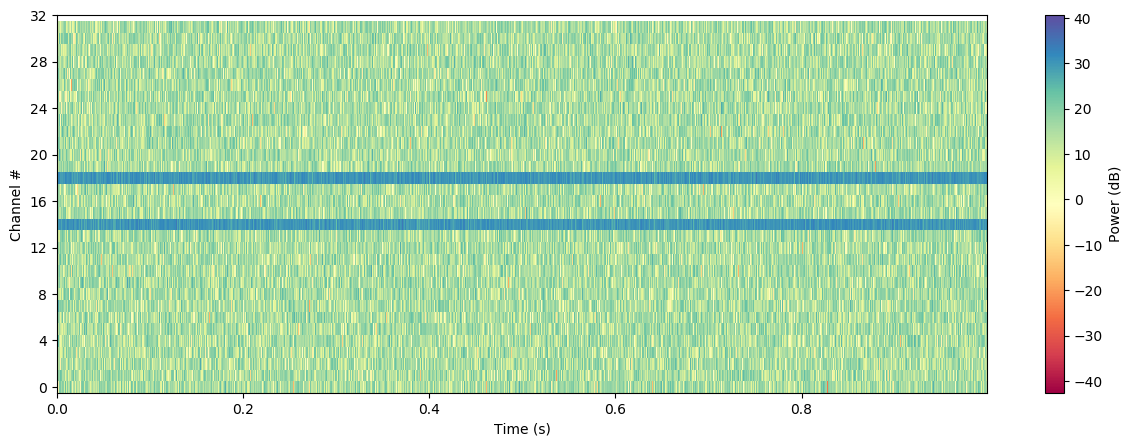

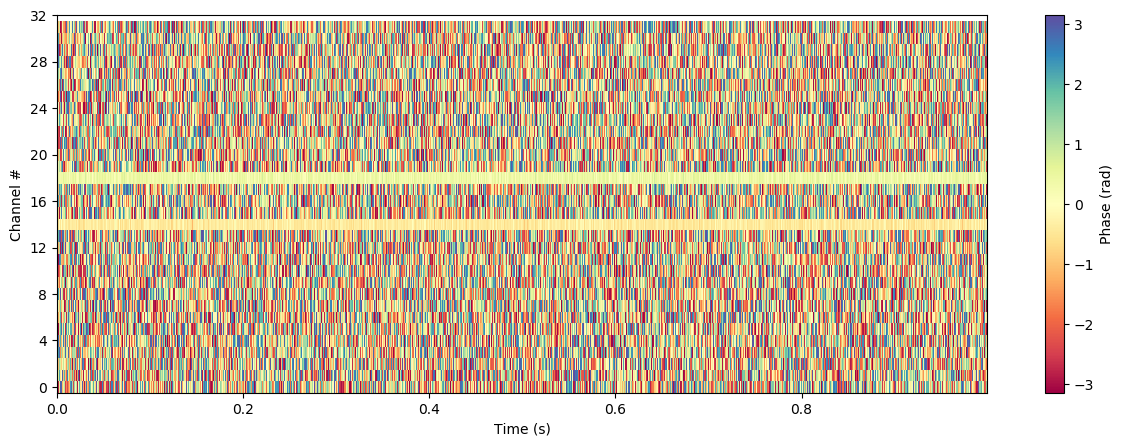

In [29]:
power  = []
powers = []
phase  = []
phases = []

for row in fftshift(ffted_signal):
    power = []
    phase = []
    for f in row:
        power.append(db(abs(f**2)))
        phase.append(cmath.phase(f))
    powers.append(power)
    phases.append(phase)

p  = np.transpose(powers)
ph = np.transpose(phases)
last_time = (nsamples-ntaps*nchan)/(1.*nsamples)

plt.figure(figsize=(15,5))
plt.imshow(p, cmap='Spectral', aspect='auto', origin='lower', extent=(0,last_time,-0.5,31.5))
plt.yticks(arange(0,33,4))
plt.colorbar(label="Power (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Channel #")
plt.show()

plt.figure(figsize=(15,5))
plt.imshow(ph, cmap='Spectral', aspect='auto', origin='lower', extent=(0,last_time,-0.5,31.5))
plt.yticks(arange(0,33,4))
plt.colorbar(label="Phase (rad)")
plt.xlabel("Time (s)")
plt.ylabel("Channel #")
plt.show()


----------------------
## Apply the inverse PFB:

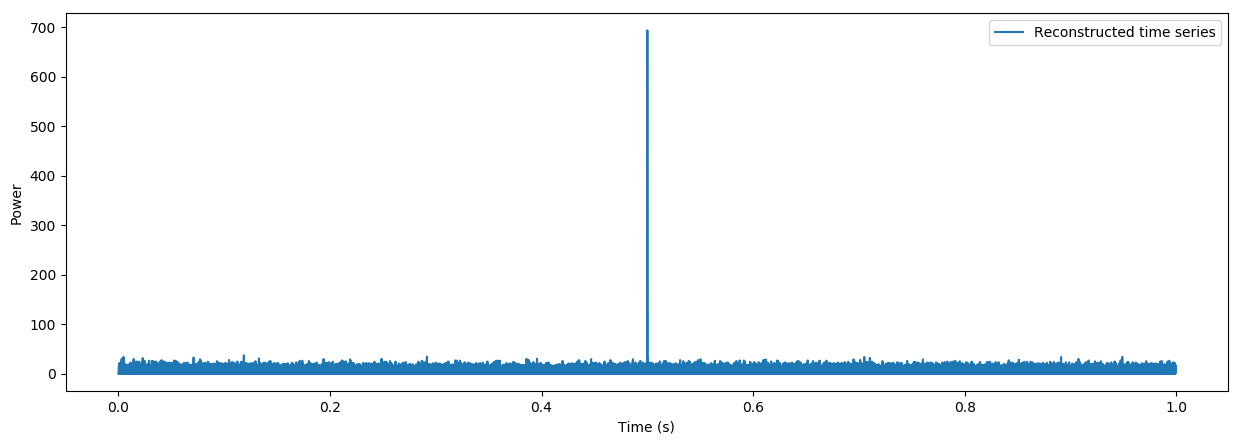

<function matplotlib.pyplot.show>

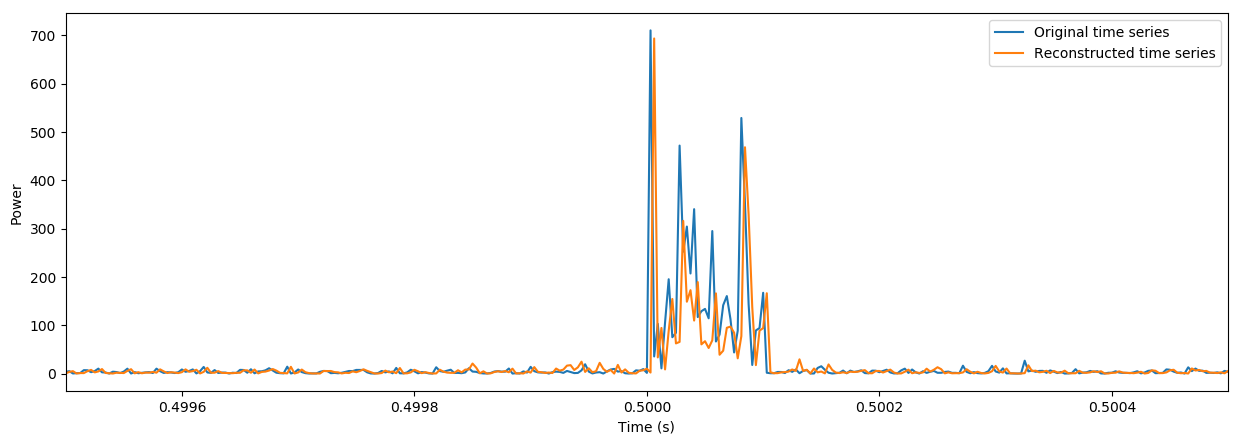

In [36]:
# the reconstruction (full)
output=[]
upsamp_factor = int(nchan/oversample_time)

for ch in range(nchan):

    channel = []
    for time_samp in range(len(ffted_signal)):
        for upsamp in range (upsamp_factor):
            # first stage is the expanding
            if (upsamp == 0):
                channel.append(ffted_signal[time_samp][ch])
            else:
                channel.append(0.0)

    #print("Upsampled channel ", ch , " to ", len(channel), " samples")

    # We now need to low pass filter this 
    # for interpolation purposes
    # we have increased the sample rate by a factor of 128
    # But the Nyquist rate for this information is still
    # the same as before 
    # which means the interpolating filter is actually the same as the FIR

    # Modulate the filter

    fir_coeff2 = [fir_coeff[i] * cmath.rect(1.0,-1.0*ch*2*i*cmath.pi/nchan) for i in range(len(fir_coeff))]

    inv_channel = lfilter(fir_coeff2,1.0,channel)

    if (ch == 0):
        for entry in inv_channel:
            output.append(entry)
    else:
        for i,entry in enumerate(inv_channel):
            output[i] = output[i] + entry

norm_factor = nchan*oversample_time
norm_output = [x/norm_factor for x in output]

plt.figure(figsize=(15,5))
plot_power(t, norm_output, "Reconstructed time series")
plt.show()

plt.figure(figsize=(15,5))
plot_power(t, signal, "Original time series")
plot_power(t, norm_output, "Reconstructed time series")
plt.xlim([0.4995,0.5005])
plt.show

(0.4995, 0.5005)

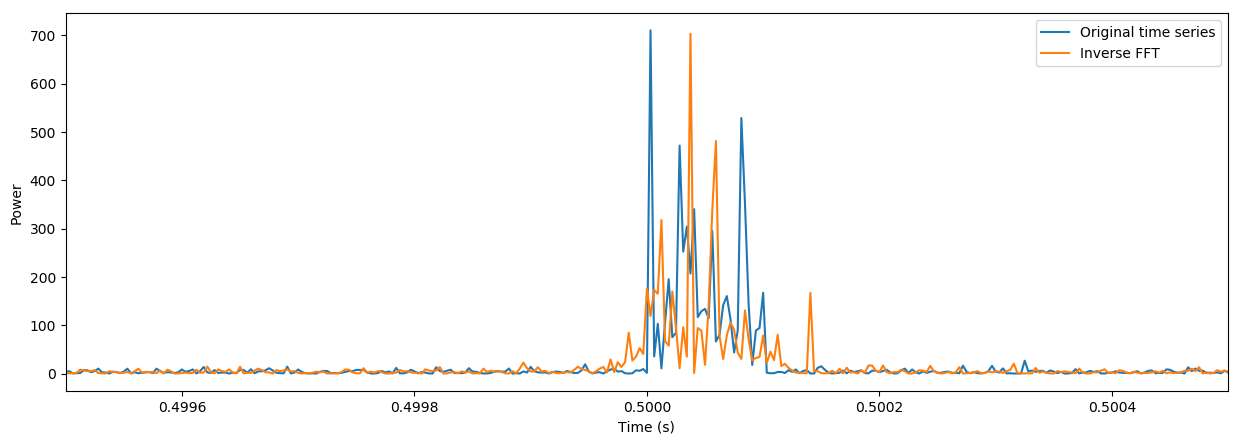

In [40]:
# Compare to what you get if you just to an inverse FFT
simple_out = []

for time_samp in range(0,len(ffted_signal)):

    to_fft=[]
    for chan_num in range (0,len(ffted_signal[time_samp])):
        chan_val = ffted_signal[time_samp][chan_num]
        to_fft.append(chan_val)
           
        
    for samp in ifft(to_fft):
        simple_out.append(samp)
        
    
#get the shift
# xcor1 = fft(simple_out)
# xcor2 = fft(output)
# xcor3 = np.conj(xcor1)*(xcor2)
# xcor4 = ifft(xcor3)

# max_index = np.argmax(xcor4)
# print(len(xcor3))
# print(max_index)

toplot = []
shifted = []
shift = 110
shifted = list(np.zeros(shift)) + simple_out

plt.figure(figsize=(15,5))
plot_power(t, signal, "Original time series")
plot_power(t, shifted, 'Inverse FFT')
plt.xlim([0.4995,0.5005])

Text(0.5,0,u'Freq (Hz)')

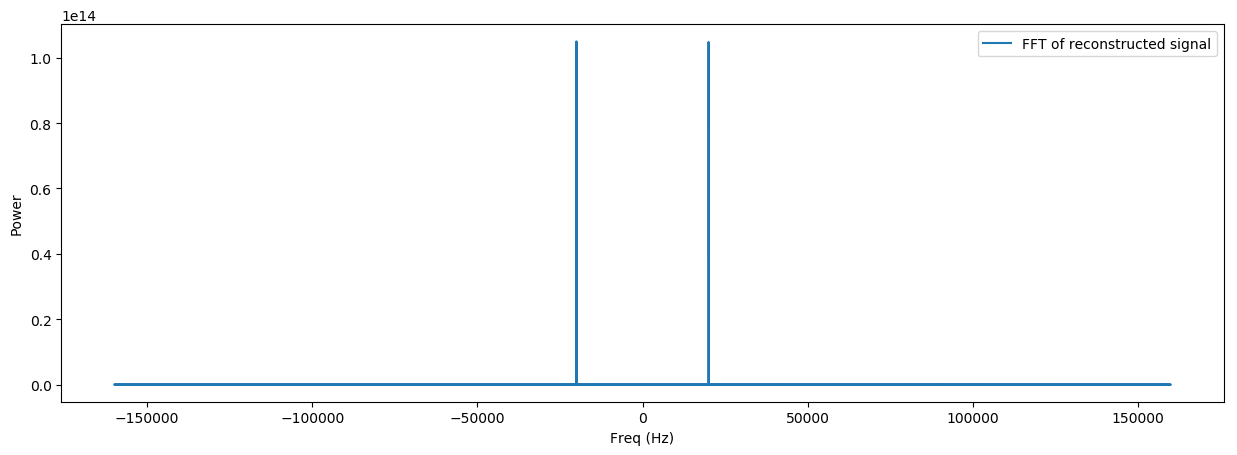

In [41]:
spectrum = fft(output)
toplot = []
for samp in spectrum:
    toplot.append(abs((samp)**2))
          
freq = fftfreq(len(spectrum), (t[1] - t[0]))

# Plot it up
plt.figure(figsize=(15,5))
plot_power(freq, spectrum, "FFT of reconstructed signal")
plt.xlabel("Freq (Hz)") 


